# Natural Language Processing with Disaster Tweets

## Description

In this competition, it is required to create a machine learning model that predicts which tweets are dedicated to real disasters and which are not.

## Loading data

In [334]:
!pip install pathlib==1.0.1 -q

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [336]:
# define the variables
DIR='./data'

In [337]:
df = pd.read_csv(f'{DIR}/train.csv', index_col='id')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


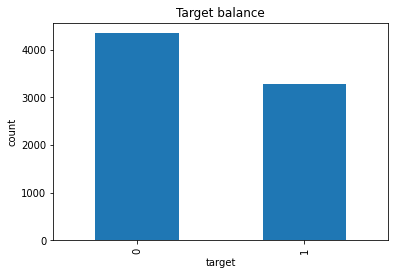

In [338]:
#balance
df['target'].value_counts().plot(kind='bar')
plt.title('Target balance')
plt.ylabel('count')
plt.xlabel('target')
plt.show()

__Note__: no significant imbalance found

### Location

In [339]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [340]:
# let's check the uniqueness
df['location'].nunique()

3341

In [341]:
df['location'] = df['location'].fillna('unknown')

In [342]:
def get_word_count(txt):
    """
    Calculating the number of words
    
    Inputs:
    -----------
    txt: string - input text
    
    Outputs:
    --------
    integer - word lengths
    """
    txt = txt.lower()
    word_tokens = word_tokenize(txt)
    
    return len(word_tokens)

df['location_word_count'] = df['location'].apply(get_word_count)

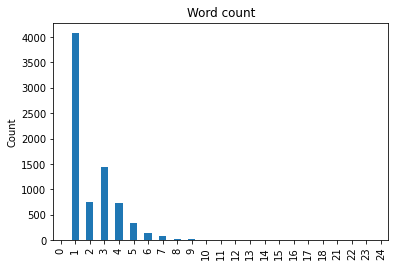

In [343]:
dfc = df['location_word_count'].value_counts()
dfc.sort_index(inplace=True)
dfc.plot(kind='bar')
plt.title('Word count')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

#### Loading intermediate data

In [344]:
# https://unece.org/trade/cefact/UNLOCODE-Download
division_code_df = pd.read_csv(f'{DIR}/2023-1 SubdivisionCodes.csv', names=['Country', 'City', 'Name', 'Type'])

division_code_df.head()

,Country,City,Name,Type
0,AD,02,Canillo,Parish
1,AD,03,Encamp,Parish
2,AD,04,La Massana,Parish
3,AD,05,Ordino,Parish
4,AD,06,Sant Juliа de Lтria,Parish


In [345]:
# get city names
names = list(division_code_df['Name'].str.lower())

In [346]:
country_df = pd.read_csv(f'{DIR}/country-list_data.csv')

country_df.head()

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


In [347]:
countries = list(country_df['Name'].str.lower())

#### Preprocessing

In [348]:
def is_country(txt):
    txt = txt.lower()
    
    for country in countries:
        if country in txt:
            return 1
    
    return 0

df['isCountry'] = df['location'].apply(is_country)

In [349]:
def is_city(txt):
    txt = txt.lower()
    
    for name in names:
        if name in txt:
            return 1
    
    return 0

df['isCity'] = df['location'].apply(is_city)

In [350]:
df['isUnknown'] = df['location'] == 'unknown'
df['isUnknown'] = df['isUnknown'].map({ True:1, False: 0 })

In [351]:
df['isOther'] = (df['isCity'] == False) & (df['isCountry'] == False) & (df['isUnknown'] == False)
df['isOther'] = df['isOther'].map({ True:1, False: 0 })

### Keyword

In [352]:
df['keyword'] = df['keyword'].fillna('unknown')

In [353]:
df['keyword'].nunique()

222

In [354]:
df['keyword'] = df['keyword'].str.replace('%20', ' ')

In [355]:
df = pd.get_dummies(df, columns=['keyword'], drop_first=True)

## Text to vector

In [356]:
import os
import torch
import pickle
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

In [357]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [358]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

In [359]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def text2vector(sentences):
    #Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    pbar.update(1)
    ar = sentence_embeddings[0].to('cpu').detach().numpy()
    return ar


if os.path.exists(DIR + '/text_vectors.pickle'):
    text_vectors = pickle.load(open(DIR + '/text_vectors.pickle', 'rb'))
    df['text_vector'] = text_vectors
else:
    with tqdm(total=df.shape[0]) as pbar:
        df['text_vector'] = df['text_vector'].apply(lambda x: text2vector(x))

    pickle.dump(df['text_vector'], file = open(DIR + '/text_vectors.pickle', 'wb'))

## Location & Keyword to vector

In [360]:
df.columns.values

array(['location', 'text', 'target', 'location_word_count', 'isCountry',
       'isCity', 'isUnknown', 'isOther', 'keyword_accident',
       'keyword_aftershock', 'keyword_airplane accident',
       'keyword_ambulance', 'keyword_annihilated', 'keyword_annihilation',
       'keyword_apocalypse', 'keyword_armageddon', 'keyword_army',
       'keyword_arson', 'keyword_arsonist', 'keyword_attack',
       'keyword_attacked', 'keyword_avalanche', 'keyword_battle',
       'keyword_bioterror', 'keyword_bioterrorism', 'keyword_blaze',
       'keyword_blazing', 'keyword_bleeding', 'keyword_blew up',
       'keyword_blight', 'keyword_blizzard', 'keyword_blood',
       'keyword_bloody', 'keyword_blown up', 'keyword_body bag',
       'keyword_body bagging', 'keyword_body bags', 'keyword_bomb',
       'keyword_bombed', 'keyword_bombing', 'keyword_bridge collapse',
       'keyword_buildings burning', 'keyword_buildings on fire',
       'keyword_burned', 'keyword_burning', 'keyword_burning buildings',


In [361]:
df['other_vector'] = df.drop(columns=['text_vector', 'text', 'location', 'target', 'location_word_count']).apply(lambda x: x.values, axis=1)

Объеденим два вектора `other_vector` и `text_vector`

In [362]:
def join_vectors(row):
    """
    Объединяем два вектора

    Параметры:
    ----------
    row: Serias

    Результаты:
    numpy.ndarray - объдинённый вектор
    """

    return np.concatenate((row['other_vector'], row['text_vector']))

df['vec'] = df.apply(join_vectors, axis=1)

In [363]:
print(f'Длина итогового вектора равна {df.iloc[0]["other_vector"].shape[0]} + {df.iloc[0]["text_vector"].shape[0]} = {len(df.iloc[0]["vec"])}')

Длина итогового вектора равна 225 + 768 = 993


## Обучение

In [364]:
# определим дополнительные переменные
RANDOM_STATE=12345
N_JOBS = 8
CV = 5

In [365]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [366]:
features = df['vec']
target = df['target']

In [367]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True)

print(f'Обучающая выборка:', features_train.shape[0])
print(f'Тестовая выборка:', features_test.shape[0])

Обучающая выборка: 5709
Тестовая выборка: 1904


In [368]:
features_train = torch.FloatTensor(list(features_train.values))
features_test = torch.FloatTensor(list(features_test.values))

target_train = torch.FloatTensor(target_train.values).reshape(-1, 1)
target_test = torch.FloatTensor(target_test.values).reshape(-1, 1)

In [369]:
class TorchStandardScaler:
    """
    Специальный класс для масштабирования Tensor
    """
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

# процесс масштабирования
scaler = TorchStandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

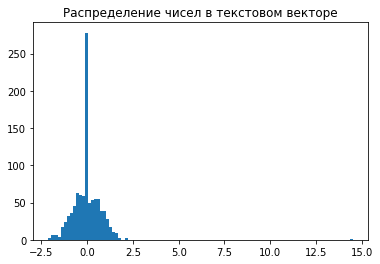

In [370]:
plt.hist(features_train[0], bins=100)

plt.title('Распределение чисел в текстовом векторе')
plt.show()

In [371]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [372]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)
model_lr.fit(features_train, target_train)

pred = model_lr.predict(features_test)
f1_lr = f1_score(target_test, pred)

print(f'F1 для LogisticRegression равно', round(f1_lr, 3))

C:\Users\a-krasnov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 для LogisticRegression равно 0.754


C:\Users\a-krasnov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [379]:
import os
import torch
import random 
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [374]:
# создание датасета
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# создадим DataLoader
train_dataset = CustomDataset(features_train, target_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(features_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# проверим работу
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 993])
Labels batch shape: torch.Size([32, 1])


In [381]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(993, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 16)
        self.fc6 = nn.Linear(16, 1)

        self.dp = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        #x = self.relu(x)
        #x = self.dp(x)

        x = self.fc2(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc3(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc4(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc5(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc6(x)

        return self.sigm(x)

In [384]:
models = Net()
models.to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(models.parameters(), lr=5e-6)

epochs = 100
nn_valid_loss = np.inf

In [386]:
%%time

# фиксируем state
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
    
for e in range(epochs):
    train_loss = 0.0
    models.train()     # Optional when not using Model Specific layer
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        target = models(data)

        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    valid_loss = 0.0
    models.eval()     # Optional when not using Model Specific layer

    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)

        target = models(data)
        loss = criterion(target, labels)
        valid_loss += loss.item()

    if e % 10 == 0:
        score = valid_loss / len(test_dataloader)
        
        print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {score}')

        if nn_valid_loss > score:
            nn_valid_loss = score

Epoch 1 		 Training Loss: 0.3419081225741509 		 Validation Loss: 0.3896797992289066
Epoch 11 		 Training Loss: 0.29284175764249026 		 Validation Loss: 0.3970001901189486


KeyboardInterrupt: 